# 目的

学習した機械学習器の学習・予測データの予測に寄与した特徴量を可視化する

## 機械学習モデルの解釈
SHAPによって、入出力値から、出力に寄与した特徴量をSHAP値で表現できる。  
しかし、前処理でPCAを実施しているため、SHAPで出力される特徴量はPCAのままである。  
このままでは出力に寄与した遺伝子名（生の特徴量）がわからないため、PCAのloading（因子負荷量：主成分と元の特徴量を標準化した変数の相関係数）をSHAPの平均絶対値と内積をとってordinal score：順序スコアを定義する。


In [2]:
# 基本的なライブラリ
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

# XAI
import shap

# config python file
import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

# SHAP

In [3]:
def save_shap_instances(
    shap_explainer: callable,
    shap_values: callable,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    functions.make_dir(save_file_path)
    functions.dill_dump(shap_explainer, "{0}/shap_explainer.pkl".format(save_file_path))
    functions.dill_dump(shap_values, "{0}/shap_values.pkl".format(save_file_path))

In [4]:
def explain_model(
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
        _y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(input_pipe_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.explainers.Permutation(
        _estimator.predict, _X, max_evals="auto", seed=config.SEED
    )
    """
    explainer = shap.Explainer(
        _estimator.predict,
        _X,
        seed=config.SEED,
    )"""
    shap_values = explainer(_X)
    # shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            save_file_path=output_file_path,
        )

In [5]:
## 全体での実行

In [6]:
# 層別化する特徴量
def exec_shap(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path: ", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

# ランキングの作成

## shap値の取得+pcaを利用した計算

In [7]:
def calc_score(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "/test_set",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    shap.plots.beeswarm(sv)
    
    #shap.summary_plot(sv,plot_type='bar')
    
    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )

    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )

    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

In [46]:
preprocess_pipeline = functions.pickle_load(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/test_set/test/preprocess_pipeline.pkl"
                                           )
pca = preprocess_pipeline[-1]
pca

PCA(n_components=0.41, random_state=100)

In [47]:
c = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/test_set/test/X.pkl"
)
df_pca29 = pd.DataFrame(
    c, columns=pca.get_feature_names_out()
)
display(df_pca29.head())

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14
0,-76.321217,-9.835925,-21.826263,-0.263736,-3.452577,12.340004,1.938628,-9.648288,-22.944421,0.401585,-10.749480,9.437693,19.049710,27.713894,14.574963
1,-39.571730,-1.816140,-43.986559,-41.548569,39.181540,-7.372463,5.214746,23.431894,2.956127,-25.728297,-4.361559,-15.227798,37.710797,-3.147417,7.517617
2,-10.942876,-25.485326,7.226996,7.171057,6.635742,-15.087906,14.347711,-30.719015,4.956674,5.232946,7.579771,2.586005,-9.012290,-3.704901,-14.465209
3,-39.189569,-8.713197,-33.381951,28.978514,10.555440,-26.635918,8.294482,10.245500,32.412876,-7.001400,11.160474,4.686033,-18.549234,-13.317777,-11.802313
4,37.876554,-38.413329,53.324483,-37.722008,-32.463006,13.787699,25.188249,2.930357,-4.345961,18.719705,-3.857524,-21.023938,5.592682,6.228902,6.968400


In [23]:
df_gene_expressions = pd.read_pickle(
     config.INTERIM_PREPROCESSED_RECURRENCE_DIR +"/df_gene_expressions.pkl"
)
df_pca29_pca5 = pd.DataFrame(
    pca.components_,
    index=pca.get_feature_names_out(),
    columns=df_gene_expressions.columns,
).T["pca5"].apply(lambda x: abs(x)).sort_values(ascending=False)

df_pca29_pca5 = pd.DataFrame(df_pca29_pca5)
df_pca29_pca5

,pca5
Hugo_Symbol,
GNG3,3.161957e-02
HPCAL4,3.018502e-02
NRXN1,2.981650e-02
SRRM4,2.975785e-02
TPPP,2.914383e-02
...,...
MUC7,1.339875e-06
PSG9,9.008652e-07
ADAM20P1,8.828874e-07


In [48]:
 loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )
l = loadings.T
l_5 = l["pca13"].apply(lambda x: abs(x)).sort_values(ascending=False)
l_5 = pd.DataFrame(l_5)
l_5.rename(columns={'pca13': 'Feature 13'})

,Feature 13
AP1G1,0.441944
DPP7,0.408799
TSSC4,0.393060
RANBP10,0.391030
CLCA2,0.374800
...,...
SLC7A8,0.000025
IREB2,0.000014
CD3G,0.000013
ATP6V1C2,0.000010


## 予測で最も性能の高かったパターンでのスコア算出

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/test_set/test
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/GradientBoostingSurvivalAnalysis/test_set
output file path:  ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/GradientBoostingSurvivalAnalysis/test_set


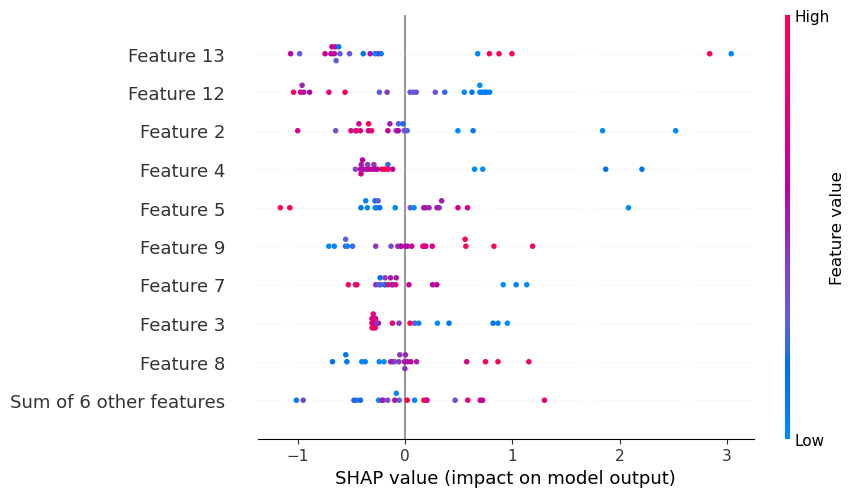

'\nmodel_order_dict = {\n    "model_name": ExtraSurvivalTrees().__class__.__name__,\n    "preprocess_name": "preprocess4numeric_pca43",\n    "subgroup_column": "CLAUDIN_SUBTYPE",\n    "subgroup": "LumA",\n}\nrank_LumA = calc_score(model_order_dict)\n\n\nmodel_order_dict = {\n    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,\n    "preprocess_name": "preprocess4numeric_pca77",\n    "subgroup_column": "CLAUDIN_SUBTYPE",\n    "subgroup": "LumB",\n}\nrank_LumB = calc_score(model_order_dict)\n\n\nmodel_order_dict = {\n    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,\n    "preprocess_name": "preprocess4numeric_pca31",\n    "subgroup_column": "CLAUDIN_SUBTYPE",\n    "subgroup": "Her2",\n}\nrank_Her2 = calc_score(model_order_dict)\n\n\nmodel_order_dict = {\n    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,\n    "preprocess_name": "preprocess4numeric_pca30",\n    "subgroup_column": "CLAUDIN_SUBTYPE",\n    "subgroup": "Normal",

In [45]:
# 修士論文
model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca41",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow = calc_score(model_order_dict)

"""
model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca43",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca77",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca31",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2 = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca30",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal = calc_score(model_order_dict)


model_order_dict = {
    "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca58",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}

rank_Basal = calc_score(model_order_dict)
"""

In [9]:
rank_claudinlow = rank_claudinlow.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA = rank_LumA.rename(columns={"gene name": "gene_LumA", "score": "score_LumA"})
rank_LumB = rank_LumB.rename(columns={"gene name": "gene_LumB", "score": "score_LumB"})
rank_Her2 = rank_Her2.rename(columns={"gene name": "gene_Her2", "score": "score_Her2"})
rank_Basal = rank_Basal.rename(columns={"gene name": "gene_Basal", "score": "Basal"})
rank_Normal = rank_Normal.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank = rank_claudinlow.copy()
df_rank = pd.merge(df_rank, rank_LumA, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_LumB, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Her2, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Normal, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Basal, right_index=True, left_index=True)
# 一時的な保存
df_rank.to_csv("./explain_score.csv")
df_rank

NameError: name 'rank_LumA' is not defined

# 晩期再発者のみの調査

In [10]:
# 層別化する特徴量
def exec_shap4late_recurrences(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/late_recurrences",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

In [11]:
# shap_valueをもとにプロット・保存を実施する関数
def plot_sv(sv):
    plt.figure(figsize=(6, 6))
    shap.plots.beeswarm(sv, show=False)
    plt.title(model_order_dict["subgroup"])
    plt.tight_layout()
    plt.savefig("./shap_{0}.png".format(model_order_dict["subgroup"]))


# 晩期再発者向けに定義した順序スコアを計算するための関数
def calc_score4late_recurrences(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap4late_recurrences(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    plot_sv(sv)

    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )

    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )

    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

In [12]:
# AROB
model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca92",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences(
    model_order_dict,
)


model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca94",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca82",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca95",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": RandomSurvivalForest().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca88",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca83",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_late = calc_score4late_recurrences(model_order_dict)

....................................................................................................
model_order_dict name:  RandomSurvivalForest
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca92/test_set/late_recurrences
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca92/RandomSurvivalForest/test_set
output file path ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca92/RandomSurvivalForest/test_set/late_recurrences
preprocess or pipeline pkl file dose not exist


FileNotFoundError: [Errno 2] No such file or directory: './../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca92/RandomSurvivalForest/test_set/late_recurrences/shap_values.pkl'

In [13]:
# 修士論文
model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca41",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences(
    model_order_dict,
)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca43",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca77",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca31",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca30",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca58",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_late = calc_score4late_recurrences(model_order_dict)

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/test_set/late_recurrences
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/GradientBoostingSurvivalAnalysis/test_set
output file path ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/GradientBoostingSurvivalAnalysis/test_set/late_recurrences
preprocess or pipeline pkl file dose not exist


FileNotFoundError: [Errno 2] No such file or directory: './../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/GradientBoostingSurvivalAnalysis/test_set/late_recurrences/shap_values.pkl'

In [14]:
rank_claudinlow_late = rank_claudinlow_late.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA_late = rank_LumA_late.rename(
    columns={"gene name": "gene_LumA", "score": "score_LumA"}
)
rank_LumB_late = rank_LumB_late.rename(
    columns={"gene name": "gene_LumB", "score": "score_LumB"}
)
rank_Her2_late = rank_Her2_late.rename(
    columns={"gene name": "gene_Her2", "score": "score_Her2"}
)
rank_Basal_late = rank_Basal_late.rename(
    columns={"gene name": "gene_Basal", "score": "Basal"}
)
rank_Normal_late = rank_Normal_late.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank_late = rank_claudinlow_late.copy()
df_rank_late = pd.merge(df_rank_late, rank_LumA_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_LumB_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_Her2_late, right_index=True, left_index=True)
df_rank_late = pd.merge(
    df_rank_late, rank_Normal_late, right_index=True, left_index=True
)
df_rank_late = pd.merge(
    df_rank_late, rank_Basal_late, right_index=True, left_index=True
)
# 一時的な保存
df_rank_late.to_csv("./explain_score_late.csv")
df_rank_late

NameError: name 'rank_claudinlow_late' is not defined

In [15]:
df_rank

NameError: name 'df_rank' is not defined

In [ ]:
df_rank_late